Note: *cudamat* is one option to do parallel computing for matrix computation

In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.io import loadmat
import random
from numpy import linalg as LA
import time
from fun1d import *
from poisson import *

from IPython import display
# from numbapro import vectorize

In [16]:
def window_filter_1d(n, s, xi, sigma):
    # generate one 1D gabor wavelet 
    x = np.arange(n)
    chi = np.zeros(n)
#     chi = gaussian(x, sigma*s)
    chi[0:s] = 1
    o = np.exp(1j * xi * x)
#     o = np.exp(1j * xi/s * x)
    
    psi = np.multiply(chi, o)
    
#     omega = 2 * pi * x / n
#     psi_hat = np.exp(-0.5 * sigma**2 * (xi - omega)**2)
    psi_hat = np.fft.fft(psi)
#     psi_hat = np.fft.fft(psi)
    return psi, psi_hat

def window_filter_family_1d(n, s, xi, sigma = 1):
    # generate a family of 1D gabor wavelets with specified scales and rotations in space
    ns = s.shape[0]
    nxi = xi.shape[0]
    
    psi = np.zeros((n, ns, nxi),dtype=complex)
    psi_hat = np.zeros((n, ns, nxi),dtype=complex)
    for i in range(ns):
        for k in range(nxi):
                psi[:, i, k], psi_hat[:, i, k] = window_filter_1d(n, int(s[i]), xi[k], sigma)
    return psi, psi_hat

def bump_filter_1d(n, s, xi):
    # generate one 1D window filter with bump function as window 
    x = np.arange(n) - np.floor(n/2)
    chi = np.zeros(n)
    z = int(n/2)
    ind = np.arange(s - 1) + z + 1
    chi[ind] = np.exp(- s**2 / (4 * s * x[ind] - 4 * x[ind]**2))
    
    o = np.exp(1j * xi * x)
#     o = np.exp(1j * xi/s * x)
    
    psi = np.multiply(chi, o)
    
    psi_hat = np.fft.fftshift(np.fft.fft(np.fft.fftshift(psi)))
    return psi, psi_hat

def bump_filter_family_1d(n, s, xi):
    # generate a family of 1D window filters with bump function as window
    ns = s.shape[0]
    nxi = xi.shape[0]
    
    psi = np.zeros((n, ns, nxi),dtype=complex)
    psi_hat = np.zeros((n, ns, nxi),dtype=complex)
    for i in range(ns):
        for k in range(nxi):
                psi[:, i, k], psi_hat[:, i, k] = bump_filter_1d(n, int(s[i]), xi[k])
    return psi, psi_hat

def diff(y0, sx, psi_hat, psi):
    # difference vector between first moment wavelet coefficients
    sy = scat_coeff(y0, psi_hat)
    diff = np.sum((sy - sx)**2)
    return diff


def synthesis(sx, x, psi_hat, psi, max_err, max_epoch, *args):
    # collect parameters
    nx = psi_hat.shape[0]
    nw = psi_hat.shape[1]  # number of wavelets 
    
    # randomly initialize new signal
    narg = len(args)
    if narg == 0:
        y0 = np.random.random(nx) 
    else:
        y0 = args[0]
    y = np.expand_dims(x, axis = 1)
    
    err = 1
    epoch = 0
    tic = time.time()
    while (epoch < max_epoch):
        
        epoch += 1
        ind = np.random.choice(nw, nw, replace = False) # randomize index of wavelets
        print('epoch:', epoch)
        
        for i in range(nw):
#             print('idx:',i)
            res = minimize(diff, y0, args = (sx[np.append([0], ind[0:i+1] + 1)], psi_hat[:,ind[0:i+1]], \
                                                         psi[:,ind[0:i+1]]), jac = jac, method='BFGS')
#             res = minimize(diff, y0, args = (sx[np.append([0], ind[0:i+1] + 1)], psi_hat[:,ind[0:i+1]], \
#                                                          psi[:,ind[0:i+1]]), method='BFGS',options = {'gtol': 1e-12})
            y0 = res.x
            y = np.append(y, np.reshape(y0, (y0.shape[0], 1)), axis = 1)
            
            err = res.fun
            print('current error:', err)
        
    toc = time.time()
    print('running time: ', toc - tic)
    return y

def jac(y0, sx, psi_hat, psi):
    # jacobian function for difference
    epsilon = 1e-6
    n = psi_hat.shape[0]
    nw = psi_hat.shape[1]
    sy = scat_coeff(y0, psi_hat)
    y_hat = np.fft.fft(np.fft.fftshift(y0))
    
    g = np.zeros(n)
    
    psi_shift = np.zeros((n,n), dtype = complex)    
    
    g = g + 2 * (sy[0] - sx[0]) * np.ones(n)
#     temp3 = temp3 + 2 * (sy[1] - sx[1]) * np.sign(y0)

    for i in range(nw):
        temp1 = np.fft.fftshift(np.fft.ifft(np.multiply(y_hat, psi_hat[:,i])))
        for p in range(n):
            psi_shift[:, p] = np.roll(psi[:,i], p, axis = 0)
        temp2 = np.matmul(np.divide(np.real(temp1), abs(temp1) + epsilon), np.real(psi_shift)) + \
                np.matmul(np.divide(np.imag(temp1), abs(temp1) + epsilon), np.imag(psi_shift))
        g = g + 2 * (sy[i+1] - sx[i+1]) * temp2
    return g

In [57]:
n = 2**8
l = 0.01
pi = math.pi
max_err = 1e-7
max_epoch = 1

epsilon = 1e-7

# define filters
sigma = determine_sigma(epsilon)
Q = 2
alpha = 2
J = determine_J(n, Q, sigma, alpha) + 1
# s = np.unique(np.floor(2 ** np.linspace(1, J, int(J*Q)+1-Q)))
s = np.array([1,2,4,8,10,16,23,31,41,63,75,118])
# xi = 2 * pi * np.random.choice(n,1) / n
xi = np.array([3 * pi / 4, 23 * pi / 128]) # choose two frequencies
g, g_hat = window_filter_family_1d(n, s, xi) # use characteristic window function
g = np.reshape(g, (g.shape[0], -1))
g_hat = np.reshape(g_hat, (g_hat.shape[0], -1))
nwave = g_hat.shape[1]
dy = np.zeros(n)
ind_dirac = np.random.choice(int(n/2), 3, replace = False) * 2 # randomly select support
dy[ind_dirac] = 1

sx = scat_coeff(dy, g_hat)

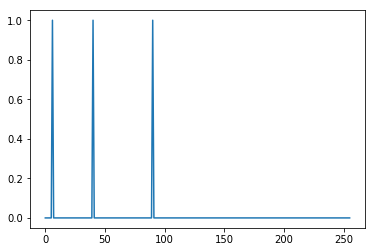

In [58]:
plt.plot(dy)

In [59]:
s

array([  1,   2,   4,   8,  10,  16,  23,  31,  41,  63,  75, 118])

In [60]:
g_hat.shape

(256, 24)

In [61]:
# plt.figure(figsize = (15,10))
# ind = np.arange(100) - 50
# for i in range(nwave):
# #     plt.subplot(5,4, i+1)
#     plt.plot(np.abs(g[:,i]))
    

In [62]:
res = synthesis(sx, dy, g_hat, g, max_err, max_epoch)

epoch: 1
current error: 5.288227175259248e-15
current error: 1.8755191344853968e-16
current error: 1.6206919820603488e-16
current error: 3.6119647594242217e-06
current error: 9.021729815111081e-08
current error: 1.0110595126648026e-07
current error: 1.0722967104668984e-07
current error: 5.650951268734288e-09
current error: 1.6796778732114674e-08
current error: 3.6773146197350574e-07
current error: 0.0012853659801475383
current error: 0.0008674777587887763
current error: 0.0010391010172004144
current error: 0.00118722208597548
current error: 0.0013870047555313474
current error: 0.07241365340472673
current error: 0.08407692697423563
current error: 0.09870437627570396
current error: 0.1634545509716589
current error: 0.40619218658414874
current error: 0.33964896394121125
current error: 0.3199980988881614
current error: 0.34581106743755236
current error: 0.3455597473659297
running time:  968.5609889030457


In [63]:
# load results synthesized by previous optimization method(add one wavelet each optimization)
# res1 = np.load('res_poisson14.npy')
# g_hat1 = np.load('g_hat3.npy')
# sx = np.load('f14.npy')
res1 = res

In [64]:
g_hat.shape

(256, 24)

Text(0.5,1,'synthesized signal')

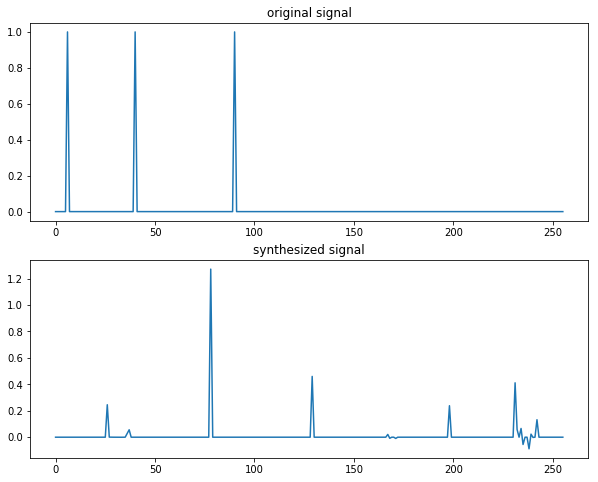

In [65]:
# fig = plt.figure()
# plt.figure(figsize = (5,5))
# plt.subplot(2,1,1)
# plt.plot(res1[:, 0]) # target signal
# plt.title('original signal')
# ax2 = plt.subplot(2,1,2)
# for i in range(res1.shape[1] - 1):
#     ax2.clear()
#     ax2.plot(res1[:, i+1]) # synthesized signal from each iteration
#     ax2.set_title('synthesized signal')
#     print(i)
#     plt.tight_layout()
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     time.sleep(0.5)

plt.figure(figsize = (10, 8))
plt.subplot(2,1,1)
plt.plot(dy) # target signal
plt.title('original signal')
ax2 = plt.subplot(2,1,2)
plt.plot(res1[:, -1])
plt.title('synthesized signal')
# plt.savefig('syn_bump')

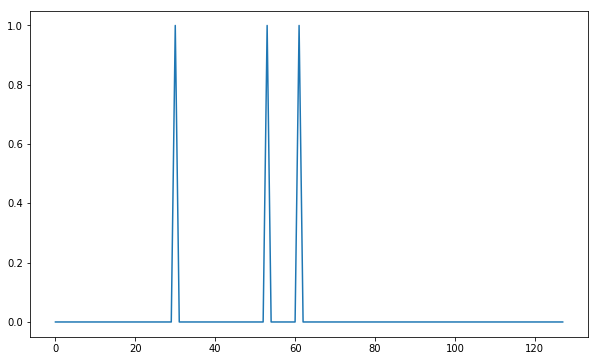

In [35]:
plt.figure(figsize = (10, 6))
plt.plot(res1[:, 0]) # target signal
# plt.plot(res1[:, -1])
plt.savefig('3-diracs')

In [116]:
y0 = res1[:,-1]
x = res1[:,0]
sy = np.sum(np.abs(wave_trans_in_freq_1d(y0, g_hat)), axis = 0)
# sy = np.append(np.sum(np.abs(y0)), sy)
sy = np.append(np.sum(y0), sy)
print('scattering of target:', sx)
print('scattering of synthesized:', sy)
print('scattering difference with wavelets in optimization process:', np.sum((sy - sx)**2))

scattering of target: [ 1.          0.36787944  0.89507372  1.12495494  1.78678408  2.44532985
  3.55127236  4.88341209  7.10392296  9.98987632 14.20780028 19.97972183
 28.41560423]
scattering of synthesized: [ 0.99998944  0.36790947  0.8950975   1.12497451  1.78679634  2.44533611
  3.55127926  4.883419    7.10393174  9.98988789 14.20781583 19.97974315
 28.41557149]
scattering difference with wavelets in optimization process: 4.22678811928459e-09
